Simulating step 0/300...
Simulating step 50/300...
Simulating step 100/300...
Simulating step 150/300...
Simulating step 200/300...
Simulating step 250/300...
Animating step 0/300...
Animating step 50/300...
Animating step 100/300...
Animating step 150/300...
Animating step 200/300...
Animating step 250/300...
Animating step 300/300...


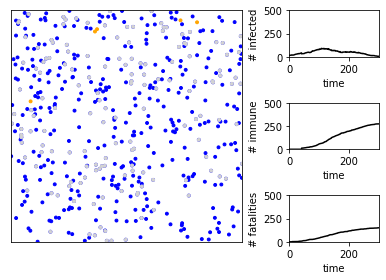

In [1]:
# %load simulation.py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from celluloid import Camera


class Person(object):
    def __init__(self, pos, vel, in_prob, out_prob, death_prob, infected=False,
                 immune=False):
        """
        Make a new person object.

        Args:
            pos (np.ndarray): The x/y position vector of the person.
            vel (np.ndarray): The x/y velocity vector of the person.
            in_prob (float): Probability to get infected in an
                             encounter with an infected person.
            out_prob (float): Probability to infect another person in
                              an encounter.
            death_prob (float): Probability of dying in a single time
                                step if person is infected.
            infected (bool): Whether the person is infected or not
            immune (bool): Whether person is immune or not
        """
        self.pos = pos
        self.vel = vel
        self.in_prob = in_prob
        self.out_prob = out_prob
        self.infected = infected
        self.immune = immune
        self.infected_since = None
        self._dead = False
        self.death_prob = death_prob

    @property
    def dead(self):
        return self._dead
    @dead.setter
    def dead(self, value):
        """
        Sets a person's status to dead. This involves setting
        their infection status to False and their velocity to zero.
        """
        if self.dead and value == False:
            raise("Zombie mode not implemented yet")
        elif ~self.dead and value == True:
            self._dead = True
            self.infected = False
            self.vel[:] = 0.0

        
class Room(object):
    def __init__(self, w, h):
        self.w = w
        self.h = h


class Simulation(object):
    def __init__(self, room, persons, prob_dist, dt, cutoff, transmit_cutoff,
                 force_constant, time_to_heal):
        """
        Arguments:
        
        - room (room): A room object
        - persons (list): A list of persons
        - prob_dist (callable): A function describing a base probability of
                                infection depending on the distance between
                                two persons
        - dt (float): Time step for numerical integration of equations of 
                      motion
        - cutoff (float): Cutoff distance between two persons below which
                          the force pushing them away from each other kicks
                          in
        - transmit_cutoff (float): Cutoff distance between two persons above
                                   which no transmission can happen
        - force_constant (float): Force constant determining strength of 
                                  interaction potential between two persons.
                                  The higher it is, the more persons bounce
                                  off each other.
        - time_to_heal (int): Number of time steps it takes for a person to
                              become healthy again after they've been infected
        """
        self.room = room
        self.persons = persons
        self.prob_dist = prob_dist
        self.dt = dt
        self.cutoff = cutoff
        self.transmit_cutoff = transmit_cutoff
        self.force_constant = force_constant
        poss = np.array([p.pos for p in self.persons])
        self._oldgrad = self.gradient(poss)
        self._current_step = 0
        self.time_to_heal = time_to_heal
        
    
    def _maybe_transmit(self, p1, p2, d):
        """
        Transmits disease between two persons depending on their distance
        
        Arguments:

        - p1 (Person): first person
        - p2 (Person): second person
        - d (float): distance between the two persons
        """
        if (p1.infected & (~p2.infected)) or ((~p1.infected) & p2.infected):
            base_prob = self.prob_dist(d)
            if p1.infected & ~p2.immune:
                total_prob = base_prob * p1.out_prob * p2.in_prob
                p2.infected = np.random.random() < total_prob
            elif p2.infected & ~p1.immune:
                total_prob = base_prob * p2.out_prob * p1.in_prob
                p1.infected = np.random.random() < total_prob


    def gradient(self, pos):
        """
        Gradient of potential energy responsable for making persons
        bounce off each other. Includes call to _maybe_transmit
        in order to avoid a second double loop.

        Arguments:
        
        - pos (np.ndarray): 2D numpy array of position vectors of
                            all persons
        """
        dm = np.linalg.norm(pos[None, :] - pos[:, None], axis=2)
        res = np.zeros(pos.shape)
        for i, pos1 in enumerate(pos):
            if self.persons[i].dead:
                ## dead persons don't interact with others
                continue
            for j, pos2 in enumerate(pos[i+1:], i+1):
                if self.persons[j].dead:
                    continue
                if dm[i,j] < self.transmit_cutoff:
                    self._maybe_transmit(self.persons[i], self.persons[j], dm[i,j])
                if dm[i,j] < self.cutoff:
                    res[i] += pos1 - pos2
                    res[j] -= pos1 - pos2
                    
        return self.force_constant * res
                

    def _bounce_off_walls(self, new_poss, old_poss, new_vels, old_vels, new_grad):
        """
        Corrects positions and velocities of persons who exceed the room limits
        
        Arguments:

        - new_poss (np.ndarray): 2D numpy array of updated position vectors
        - old_poss (np.ndarray): 2D numpy array of old position vectors
        - new_vels (np.ndarray): 2D numpy array of updated velocity vectors
        - old_vels (np.ndarray): 2D numpy array of old velocity vectors
        - new_grad (np.ndarray): updated gradient vector (equivalent to 
                                 acceleration of persons)

        Returns:

        - (new_poss, new_vels, new_grad): corrected positions, velocities,
                                          and gradient
        """
        ## left and right wall
        # person exceeds left wall, but is within upper and lower walls
        l_coll = (new_poss[:,0] < 0) & (new_poss[:,1] > 0) \
            & (new_poss[:,1] < self.room.h)
        # person exceeds right wall, but is within upper and lower walls
        r_coll = (new_poss[:,0] > self.room.w) & (new_poss[:,1] > 0) \
            & (new_poss[:,1] < self.room.h)
        ## if it's either or...
        either_r_l = l_coll | r_coll
        ## restore previous x-position and...
        new_poss[either_r_l,0] = old_poss[either_r_l,0]
        ## set y-position after bounce-off. Angle of incidence equals angle
        ## of reflection. Take a piece of paper and check for your self that
        ## this works
        new_poss[either_r_l,1] += (new_poss[either_r_l,1] - old_poss[either_r_l,1])
        ## y-component of velocity stays the same, but x-component is reversed
        new_vels[either_r_l] = old_vels[either_r_l] * np.array([-1, 1])[None,:]
        ## no force acting right after reflection
        new_grad[either_r_l] = 0.0

        ## lower and upper wall
        # yadda yadda, it's basically the same as above 
        ll_coll = (new_poss[:,1] < 0) & (new_poss[:,0] > 0) \
            & (new_poss[:,0] < self.room.w)
        u_coll = (new_poss[:,1] > self.room.h) & (new_poss[:,0] > 0) \
            & (new_poss[:,0] < self.room.w)
        either_ll_u = ll_coll | u_coll
        new_poss[either_ll_u,1] = old_poss[either_ll_u,1]
        new_poss[either_ll_u,0] += (new_poss[either_ll_u,0] - old_poss[either_ll_u,0])
        new_vels[either_ll_u] = old_vels[either_ll_u] * np.array([1, -1])[None,:]
        new_grad[either_ll_u] = 0.0

        ## if a person is exceeding both a horizontal and a vertical wall,
        ## they probably just wander off to infinity... transcending the
        ## situation, so to say
        ## Fix that if you like

        return new_poss, new_vels, new_grad


    def _integration_step(self, poss, vels):
        """
        One single velocity Verlet integration step

        Arguments:

        - poss (np.ndarray): 2D numpy array of position vectors
        - vels (np.ndarray): 2D numpy array of velocity vectors

        Returns:

        - (poss, vels, new_grad): Updated positions, velocities, and gradient
        """
        poss = poss.copy()
        vels = vels.copy()
        poss += vels * self.dt + 0.5 * self._oldgrad * self.dt * self.dt
        new_grad = self.gradient(poss)
        vels += 0.5 * (self._oldgrad + new_grad) * self.dt

        return poss, vels, new_grad
    
    
    def _move_persons(self):
        """
        Update movement of all persons during one time step
        """
        old_poss = np.array([p.pos for p in self.persons])
        old_vels = np.array([p.vel for p in self.persons])
        new_poss, new_vels, new_grad = self._integration_step(old_poss,
                                                              old_vels)
        new_poss, new_vels, new_grad = self._bounce_off_walls(new_poss,
                                                              old_poss,
                                                              new_vels,
                                                              old_vels,
                                                              new_grad)

        ## we cache the gradient
        self._oldgrad = new_grad

        for i, (pos, vel) in enumerate(zip(new_poss, new_vels)):
            self.persons[i].pos = pos
            self.persons[i].vel = vel
        

    def step(self):
        """
        Advance the simulation by one time step.
        """
        self._move_persons()

        for p in self.persons:
            if p.dead:
                ## some bug somewhere necessitates to do this again
                p.vel[:] = 0.0
            elif p.infected:
                if p.infected_since is None:
                    p.infected_since = self._current_step
                elif self._current_step - p.infected_since >= self.time_to_heal:
                    p.infected = False
                    p.immune = True
                else:
                    if np.random.random() < p.death_prob:
                        p.dead = True
        self._current_step += 1
                    


def plot_infected(step, poss, all_infected, sim, main_ax, count_ax):
    current = all_infected[step]
    inf_circles = [plt.Circle(pos, radius=sim.cutoff / 2, linewidth=0)
                   for pos in poss[current]]
    inf_c = matplotlib.collections.PatchCollection(inf_circles, color="orange")
    main_ax.add_collection(inf_c)
    count_ax.plot(np.sum(all_infected[:step + 1], axis=1), color='black')
    count_ax.set_xlabel('time')
    count_ax.set_ylabel('# infected')


def plot_notinfected(step, poss, all_infected, sim, main_ax):
    current = ~all_infected[step]
    not_inf_circles = [plt.Circle(pos, radius=sim.cutoff / 2, linewidth=0)
                       for pos in poss[current]]
    not_inf_c = matplotlib.collections.PatchCollection(not_inf_circles, color="blue")
    main_ax.add_collection(not_inf_c)
    

def plot_dead(step, poss, all_fatalities, sim, main_ax, count_ax):
    current = all_fatalities[step]
    dead_circles = [plt.Circle(pos, radius=sim.cutoff / 2, linewidth=1)
                    for pos in poss[current]]
    dead_c = matplotlib.collections.PatchCollection(dead_circles, color="lightgray")
    main_ax.add_collection(dead_c)
    count_ax.plot(np.sum(all_fatalities[:step + 1], axis=1), color='black')
    count_ax.set_xlabel('time')
    count_ax.set_ylabel('# fatalities')


def plot_immune(step, all_immune, immune_ax):
    immune_ax.plot(np.sum(all_immune[:step + 1], axis=1), color='black')
    immune_ax.set_xlabel('time')
    immune_ax.set_ylabel('# immune')


def setup_axes(fig, room, n_steps, n_persons):
    gs = gridspec.GridSpec(3, 4)
    
    main_ax = fig.add_subplot(gs[:,:3])
    main_ax.set_xlim((0, room.w))
    main_ax.set_ylim((0, room.h))
    main_ax.set_aspect('equal')
    main_ax.set_xticks(())
    main_ax.set_yticks(())

    inf_ax = fig.add_subplot(gs[0,3])
    inf_ax.set_xlim((0, n_steps))
    inf_ax.set_ylim((0, n_persons))

    immune_ax = fig.add_subplot(gs[1,3])
    immune_ax.set_xlim((0, n_steps))
    immune_ax.set_ylim((0, n_persons))

    fatalities_ax = fig.add_subplot(gs[2,3])
    fatalities_ax.set_xlim((0, n_steps))
    fatalities_ax.set_ylim((0, n_persons))

    return main_ax, inf_ax, immune_ax, fatalities_ax


## Initialize simulation
n_persons = 500
room = Room(80, 80)
# persons start with random positions and velocities
persons = [Person(np.random.uniform(low=(0,0), high=(room.w, room.h)),
                  np.random.uniform(low=(-2, -2), high=(2, 2), size=2),
                  1., 1., 0.01, False)
           for _ in range(n_persons)]
# some persons actually start out being infected
chosen_ones = np.random.choice(np.arange(n_persons), n_persons // 50)
for i in chosen_ones:
    persons[i].infected = True
sim = Simulation(room, persons, lambda d:  d < 1,
                 dt=0.1,
                 cutoff=1,
                 transmit_cutoff=2,
                 force_constant=20,
                 time_to_heal=40)

## Run simulation
n_steps = 300
all_positions = [np.array([p.pos for p in sim.persons])]
all_infected = [np.array([True if p.infected else False
                          for i, p in enumerate(sim.persons)])]
all_immune = [np.array([p.immune for p in sim.persons])]
all_fatalities = [np.array([p.dead for p in sim.persons])]

for i in range(n_steps):
    if i % 50 == 0:
        print(f"Simulating step {i}/{n_steps}...")
    sim.step()

    ## keep track of all positions, infection status, immunity
    ## status and dead persons
    poss = np.array([p.pos for p in sim.persons])
    all_positions.append(poss)
    infected = np.array([p.infected for p in sim.persons])
    all_infected.append(infected)
    immune = np.array([p.immune for p in sim.persons])
    all_immune.append(immune)
    fatalities = np.array([p.dead for p in sim.persons])
    all_fatalities.append(fatalities)


## Animate everything
fig = plt.figure()
camera = Camera(fig)
main_ax, inf_ax, immune_ax, fatalities_ax = setup_axes(fig, room,
                                                       n_steps, n_persons)
for step, poss in enumerate(all_positions):
    if step % 50 == 0:
        print(f"Animating step {step}/{n_steps}...")
    plot_infected(step, poss, all_infected, sim, main_ax, inf_ax)
    plot_notinfected(step, poss, all_infected, sim, main_ax)
    plot_dead(step, poss, all_fatalities, sim, main_ax, fatalities_ax)
    plot_immune(step, all_immune, immune_ax)

    fig.tight_layout()
    camera.snap()

anim = camera.animate(blit=True)
anim.save("output.mp4", fps=10)


In [3]:
from IPython.display import Video
Video("output.mp4")